In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\kisho\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/loan_data.csv")  # <<-- put your dataset here
columns_expected = [
    'person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp',
    'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status'
 ]
missing = [c for c in columns_expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Map "loan_status" to binary: 1 = default/charged off, 0 = paid
status_map = {
    "Fully Paid": 0, "Fully paid": 0, "FULLY PAID": 0, "Fully Paid ": 0,
    "Charged Off": 1, "Charged off": 1, "CHARGED OFF": 1, "Default": 1, "default": 1,
    "No Default": 0, "no default": 0
}
if df['loan_status'].dtype.kind in 'biufc' and df['loan_status'].nunique() <= 2:
    y = df['loan_status'].astype(int)
else:
    y = df['loan_status'].map(lambda x: status_map.get(str(x).strip(), 0)).astype(int)

features = [
    'person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp',
    'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file'
 ]
X_df = df[features].copy()

print("Dataset shape:", X_df.shape, "Target positive ratio:", y.mean())

Dataset shape: (45000, 13) Target positive ratio: 0.2222222222222222


In [3]:
from sklearn.utils import resample

def preprocess_data(X_df, y, sample_size=10000):
    # Automatically detect numeric and categorical columns
    cat_cols = X_df.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()

    # numerical
    X_num = X_df[num_cols].fillna(X_df[num_cols].median())

    # categorical
    X_cat = X_df[cat_cols].fillna("missing")
    X_cat_enc = pd.get_dummies(X_cat.astype(str), drop_first=True)

    # scale numerical
    scaler = StandardScaler()
    X_num_scaled = pd.DataFrame(
        scaler.fit_transform(X_num), columns=num_cols, index=X_num.index
    )

    # final features
    X_all = pd.concat([X_num_scaled, X_cat_enc], axis=1).fillna(0).astype(np.float32)

    # combine with target
    df = pd.concat([X_all, y], axis=1)

    # split before sampling
    X_sub = df.drop(columns=[y.name])
    y_sub = df[y.name]
    X_train, X_val, y_train, y_val = train_test_split(
        X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub
    )

    # sample (balance) only training set
    train_df = pd.concat([X_train, y_train], axis=1)
    classes = train_df[y.name].unique()
    n_per_class = int((sample_size * 0.8) // len(classes))
    df_sampled = []
    for c in classes:
        df_c = train_df[train_df[y.name] == c]
        df_c_sample = resample(df_c,
                               replace=True,
                               n_samples=n_per_class,
                               random_state=42)
        df_sampled.append(df_c_sample)
    train_sample = pd.concat(df_sampled).sample(frac=1, random_state=42)
    X_train_sample = train_sample.drop(columns=[y.name])
    y_train_sample = train_sample[y.name]

    # sample validation set to sample_size * 0.2
    val_df = pd.concat([X_val, y_val], axis=1)
    val_sample = val_df.sample(n=int(sample_size * 0.2), random_state=42)
    X_val_sample = val_sample.drop(columns=[y.name])
    y_val_sample = val_sample[y.name]

    return (
        jnp.array(X_train_sample.values),
        jnp.array(X_val_sample.values),
        jnp.array(y_train_sample.values).reshape(-1, 1),
        jnp.array(y_val_sample.values).reshape(-1, 1),
    )

# usage
X_train, X_val, y_train, y_val = preprocess_data(X_df, y, sample_size=10000)
print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (8000, 22) Val: (2000, 22)


In [4]:
# ----------------------------------------------------
# 4. Bayesian Neural Network (BNN) Model (updated priors)
# ----------------------------------------------------
def bnn_model(X, Y=None, D_H=10, D_Y=1):
    N, D_X = X.shape

    # layer 1
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), 0.5 * jnp.ones((D_X, D_H))))
    b1 = numpyro.sample("b1", dist.Normal(jnp.zeros(D_H), 0.5 * jnp.ones(D_H)))
    z1 = jnp.tanh(jnp.matmul(X, w1) + b1)

    # layer 2
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), 0.5 * jnp.ones((D_H, D_H))))
    b2 = numpyro.sample("b2", dist.Normal(jnp.zeros(D_H), 0.5 * jnp.ones(D_H)))
    z2 = jnp.tanh(jnp.matmul(z1, w2) + b2)

    # output layer
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), 0.5 * jnp.ones((D_H, D_Y))))
    b3 = numpyro.sample("b3", dist.Normal(jnp.zeros(D_Y), 0.5 * jnp.ones(D_Y)))
    logits = jnp.matmul(z2, w3) + b3

    # likelihood
    with numpyro.plate("data", N):
        numpyro.sample("Y", dist.Bernoulli(logits=logits).to_event(1), obs=Y)


In [6]:
# ----------------------------------------------------
# 5. Training with HMC/NUTS
# ----------------------------------------------------
def run_hmc(X_train, y_train, D_H=20, num_warmup=1000, num_samples=2000):
    rng_key = random.PRNGKey(0)
    kernel = NUTS(bnn_model)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=1)
    mcmc.run(rng_key, X_train, y_train, D_H, 1)
    mcmc.print_summary()
    return mcmc.get_samples()

samples = run_hmc(X_train, y_train, D_H=20, num_warmup=1000, num_samples=2000)

sample: 100%|██████████| 3000/3000 [47:51<00:00,  1.04it/s, 511 steps of size 1.01e-02. acc. prob=0.92]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]      0.07      0.69      0.06     -1.07      1.21    155.63      1.00
     b1[1]     -0.02      0.68     -0.08     -1.10      1.08    146.51      1.02
     b1[2]     -0.04      0.76     -0.02     -1.28      1.20     52.33      1.02
     b1[3]     -0.06      0.67     -0.06     -1.07      1.08    145.28      1.00
     b1[4]      0.01      0.69      0.03     -1.08      1.14    129.43      1.00
     b1[5]     -0.03      0.66     -0.01     -1.10      1.04    130.13      1.00
     b1[6]     -0.02      0.68     -0.01     -1.11      1.13    135.02      1.01
     b1[7]     -0.09      0.69     -0.08     -1.22      1.00    131.10      1.01
     b1[8]      0.04      0.66      0.05     -1.09      1.08    179.68      1.00
     b1[9]     -0.01      0.69     -0.02     -1.20      1.06     92.16      1.01
    b1[10]      0.08      0.75      0.06     -1.14      1.32     87.64      1.00
    b1[11]      0.07      0

In [8]:
# ----------------------------------------------------
# 6. Prediction
# ----------------------------------------------------
import jax
def predict(samples, X, D_H=20):
    def forward(params, X):
        w1, b1 = params["w1"], params["b1"]
        w2, b2 = params["w2"], params["b2"]
        w3, b3 = params["w3"], params["b3"]

        z1 = jnp.tanh(jnp.matmul(X, w1) + b1)
        z2 = jnp.tanh(jnp.matmul(z1, w2) + b2)
        logits = jnp.matmul(z2, w3) + b3
        return jnp.squeeze(jax.nn.sigmoid(logits))  # sigmoid

    preds = []
    for i in range(len(samples["w1"])):
        params = {k: v[i] for k, v in samples.items()}
        preds.append(forward(params, X))
    
    preds_stack = jnp.stack(preds)
    mean_pred = jnp.mean(preds_stack, axis=0)
    uncertainty = jnp.std(preds_stack, axis=0)
    
    return mean_pred, uncertainty

probs_val, uncertainty_val = predict(samples, X_val)
preds_val = (probs_val >= 0.5).astype(int)

In [9]:
# ----------------------------------------------------
# 7. Evaluation
# ----------------------------------------------------
print("\nValidation Results:")
print(classification_report(y_val, preds_val))
print("ROC AUC:", roc_auc_score(y_val, probs_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, preds_val))



Validation Results:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1559
           1       0.71      0.89      0.79       441

    accuracy                           0.89      2000
   macro avg       0.84      0.89      0.86      2000
weighted avg       0.91      0.89      0.90      2000

ROC AUC: 0.9692692129235702
Confusion Matrix:
 [[1396  163]
 [  49  392]]


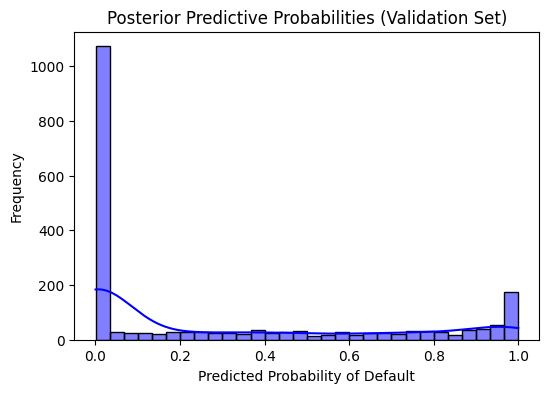

In [10]:
# ----------------------------------------------------
# 8. Visualization of Uncertainty
# ----------------------------------------------------
plt.figure(figsize=(6,4))
sns.histplot(probs_val, bins=30, kde=True, color="blue")
plt.title("Posterior Predictive Probabilities (Validation Set)")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Frequency")
plt.show()

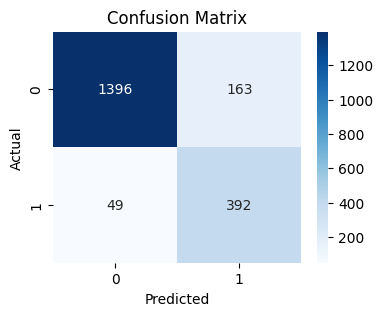

In [11]:
cm = confusion_matrix(y_val, preds_val)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


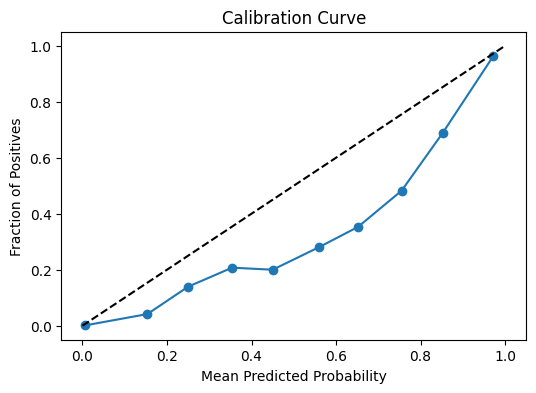

In [12]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, probs_val, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.show()
# ...existing code...

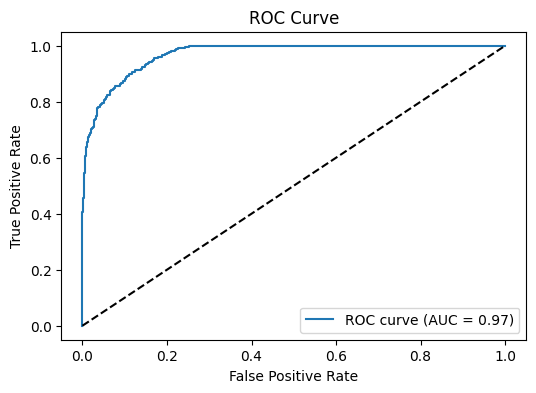

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, probs_val)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % roc_auc_score(y_val, probs_val))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

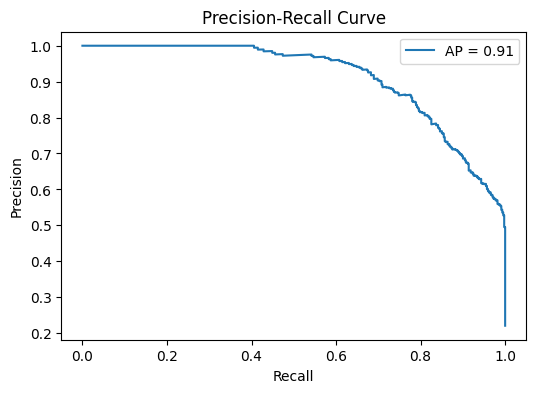

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_val, probs_val)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="AP = %.2f" % average_precision_score(y_val, probs_val))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [22]:
# Create a new loan applicant with normal (unscaled) values
new_applicant = pd.DataFrame({
    'person_age': [35],
    'person_gender': ['Male'],
    'person_education': ['Bachelor'],
    'person_income': [75000],               # Higher income
    'person_emp_exp': [8],
    'person_home_ownership': ['OWN'],       # Owns home (more stable)
    'loan_amnt': [15000],                   # Smaller loan amount
    'loan_intent': ['HOMEIMPROVEMENT'],     # More conservative purpose
    'loan_int_rate': [8.5],                 # Much lower interest rate
    'loan_percent_income': [0.20],          # Much lower ratio (20% vs 38%)
    'cb_person_cred_hist_length': [15],     # Longer credit history
    'credit_score': [750],                  # Higher credit score
    'previous_loan_defaults_on_file': ['No']
})

print("New applicant details:")
print(new_applicant)

New applicant details:
   person_age person_gender person_education  person_income  person_emp_exp  \
0          35          Male         Bachelor          75000               8   

  person_home_ownership  loan_amnt      loan_intent  loan_int_rate  \
0                   OWN      15000  HOMEIMPROVEMENT            8.5   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                  0.2                          15           750   

  previous_loan_defaults_on_file  
0                             No  


In [23]:
# Use the exact same preprocessing as your training dataset
# We need to store the feature names from training to ensure consistency

# First, let's recreate the training preprocessing to get the exact feature set
def get_training_features(X_df, y):
    """Get the exact feature columns used in training"""
    cat_cols = X_df.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # numerical
    X_num = X_df[num_cols].fillna(X_df[num_cols].median())
    
    # categorical
    X_cat = X_df[cat_cols].fillna("missing")
    X_cat_enc = pd.get_dummies(X_cat.astype(str), drop_first=True)
    
    # scale numerical
    scaler = StandardScaler()
    X_num_scaled = pd.DataFrame(
        scaler.fit_transform(X_num), columns=num_cols, index=X_num.index
    )
    
    # final features
    X_all = pd.concat([X_num_scaled, X_cat_enc], axis=1).fillna(0).astype(np.float32)
    
    return X_all.columns.tolist(), scaler, X_num[num_cols].median()

# Get training feature structure
training_features, training_scaler, training_medians = get_training_features(X_df, y)
print(f"Training features count: {len(training_features)}")

# Now preprocess the new sample to match exactly
def preprocess_new_sample(new_applicant, X_df, training_features, training_scaler, training_medians):
    """Preprocess new sample to match training data exactly"""
    
    # Combine with training data to ensure same categorical encoding
    combined_df = pd.concat([X_df, new_applicant], ignore_index=True)
    
    cat_cols = combined_df.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = combined_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # numerical - use training medians for filling
    X_num = combined_df[num_cols].fillna(training_medians)
    
    # categorical
    X_cat = combined_df[cat_cols].fillna("missing")
    X_cat_enc = pd.get_dummies(X_cat.astype(str), drop_first=True)
    
    # scale numerical using training scaler
    X_num_scaled = pd.DataFrame(
        training_scaler.transform(X_num), columns=num_cols, index=X_num.index
    )
    
    # final features
    X_all = pd.concat([X_num_scaled, X_cat_enc], axis=1).fillna(0).astype(np.float32)
    
    # Ensure we have exactly the same columns as training
    for col in training_features:
        if col not in X_all.columns:
            X_all[col] = 0.0  # Add missing columns with zeros
    
    # Keep only training features in the same order
    X_all = X_all[training_features]
    
    # Return the last row (new sample)
    return jnp.array(X_all.iloc[-1:].values)

# Preprocess the new sample correctly
new_sample_processed = preprocess_new_sample(new_applicant, X_df, training_features, training_scaler, training_medians)

print(f"New sample shape: {new_sample_processed.shape}")
print(f"Expected shape: (1, {len(training_features)})")

Training features count: 22
New sample shape: (1, 22)
Expected shape: (1, 22)


In [24]:
# Use your trained BNN model to predict on the new sample
prob_new, uncertainty_new = predict(samples, new_sample_processed)

print(f"\n=== BNN Prediction Results ===")
print(f"Predicted probability of default: {float(prob_new):.4f}")
print(f"Uncertainty (std): {float(uncertainty_new):.4f}")
print(f"Prediction: {'Default' if prob_new >= 0.5 else 'No Default'}")
print(f"Loan decision: {'REJECT' if prob_new >= 0.5 else 'APPROVE'}")

# Confidence assessment
if float(uncertainty_new) < 0.05:
    confidence = "HIGH"
elif float(uncertainty_new) < 0.15:
    confidence = "MEDIUM"
else:
    confidence = "LOW"

print(f"Model confidence: {confidence}")
print(f"95% confidence interval: [{float(prob_new - 2*uncertainty_new):.4f}, {float(prob_new + 2*uncertainty_new):.4f}]")


=== BNN Prediction Results ===
Predicted probability of default: 0.0209
Uncertainty (std): 0.0442
Prediction: No Default
Loan decision: APPROVE
Model confidence: HIGH
95% confidence interval: [-0.0676, 0.1094]


In [26]:
# Create a TRICKY rejection case - looks good but has subtle red flags
tricky_applicant = pd.DataFrame({
    'person_age': [28],                      # Young but reasonable
    'person_gender': ['Female'],
    'person_education': ['Master'],          # ✅ Good education
    'person_income': [55000],                # Decent income
    'person_emp_exp': [3],                   # ⚠️ Short employment (only 3 years)
    'person_home_ownership': ['RENT'],       # ⚠️ Renting (less stable)
    'loan_amnt': [35000],                    # 🚩 Large loan amount
    'loan_intent': ['DEBTCONSOLIDATION'],    # 🚩 Debt consolidation (already in debt trouble)
    'loan_int_rate': [18.75],                # 🚩 Very high interest rate (high risk category)
    'loan_percent_income': [0.64],           # 🚩 VERY HIGH debt ratio (64%!)
    'cb_person_cred_hist_length': [6],       # ⚠️ Short credit history
    'credit_score': [650],                   # ⚠️ Below average credit score
    'previous_loan_defaults_on_file': ['No'] # ✅ No previous defaults
})

print("=== Tricky Applicant (Should be REJECTED) ===")
print(tricky_applicant)

# Preprocess this tricky sample
tricky_sample_processed = preprocess_new_sample(tricky_applicant, X_df, training_features, training_scaler, training_medians)

# Predict on tricky sample
prob_tricky, uncertainty_tricky = predict(samples, tricky_sample_processed)

print(f"\n=== Tricky Applicant BNN Results ===")
print(f"Predicted probability of default: {float(prob_tricky):.4f}")
print(f"Uncertainty (std): {float(uncertainty_tricky):.4f}")
print(f"Prediction: {'Default' if prob_tricky >= 0.5 else 'No Default'}")
print(f"Loan decision: {'REJECT' if prob_tricky >= 0.5 else 'APPROVE'}")

# Confidence assessment
if float(uncertainty_tricky) < 0.05:
    confidence = "HIGH"
elif float(uncertainty_tricky) < 0.15:
    confidence = "MEDIUM"
else:
    confidence = "LOW"

print(f"Model confidence: {confidence}")
print(f"95% confidence interval: [{float(prob_tricky - 2*uncertainty_tricky):.4f}, {float(prob_tricky + 2*uncertainty_tricky):.4f}]")

print(f"\n=== Why This Should Be REJECTED ===")
print(f"🚩 Debt-to-income ratio: {tricky_applicant['loan_percent_income'].iloc[0]:.1%} (EXTREMELY HIGH)")
print(f"🚩 Interest rate: {tricky_applicant['loan_int_rate'].iloc[0]:.1f}% (Very high risk)")
print(f"🚩 Debt consolidation: Already struggling with existing debt")
print(f"🚩 Large loan amount: ${tricky_applicant['loan_amnt'].iloc[0]:,}")
print(f"⚠️ Short employment: Only {tricky_applicant['person_emp_exp'].iloc[0]} years")
print(f"⚠️ Credit score: {tricky_applicant['credit_score'].iloc[0]} (below average)")

=== Tricky Applicant (Should be REJECTED) ===
   person_age person_gender person_education  person_income  person_emp_exp  \
0          28        Female           Master          55000               3   

  person_home_ownership  loan_amnt        loan_intent  loan_int_rate  \
0                  RENT      35000  DEBTCONSOLIDATION          18.75   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.64                           6           650   

  previous_loan_defaults_on_file  
0                             No  

=== Tricky Applicant BNN Results ===
Predicted probability of default: 0.9991
Uncertainty (std): 0.0028
Prediction: Default
Loan decision: REJECT
Model confidence: HIGH
95% confidence interval: [0.9935, 1.0046]

=== Why This Should Be REJECTED ===
🚩 Debt-to-income ratio: 64.0% (EXTREMELY HIGH)
🚩 Interest rate: 18.8% (Very high risk)
🚩 Debt consolidation: Already struggling with existing debt
🚩 Large loan amount: $35,000
⚠️ Short employmen

In [27]:
# Create a BORDERLINE case - mixed signals that should confuse the model
borderline_applicant = pd.DataFrame({
    'person_age': [42],                      # ✅ Mature age (good)
    'person_gender': ['Male'],
    'person_education': ['Bachelor'],        # ✅ Good education
    'person_income': [68000],                # ✅ Decent income
    'person_emp_exp': [12],                  # ✅ Long employment history
    'person_home_ownership': ['OWN'],        # ✅ Owns home (stable)
    'loan_amnt': [28000],                    # ⚠️ Moderate loan amount
    'loan_intent': ['PERSONAL'],            # ⚠️ Less conservative purpose
    'loan_int_rate': [12.8],                # ⚠️ Moderate interest rate (mixed signal)
    'loan_percent_income': [0.41],          # 🚩 Just above risky threshold (41%)
    'cb_person_cred_hist_length': [18],     # ✅ Very long credit history
    'credit_score': [695],                  # ⚠️ Right on the borderline (average)
    'previous_loan_defaults_on_file': ['No'] # ✅ No previous defaults
})

print("=== Borderline Applicant (Model Should Be CONFUSED) ===")
print(borderline_applicant)

# Preprocess this borderline sample
borderline_sample_processed = preprocess_new_sample(borderline_applicant, X_df, training_features, training_scaler, training_medians)

# Predict on borderline sample
prob_borderline, uncertainty_borderline = predict(samples, borderline_sample_processed)

print(f"\n=== Borderline Applicant BNN Results ===")
print(f"Predicted probability of default: {float(prob_borderline):.4f}")
print(f"Uncertainty (std): {float(uncertainty_borderline):.4f}")
print(f"Prediction: {'Default' if prob_borderline >= 0.5 else 'No Default'}")
print(f"Loan decision: {'REJECT' if prob_borderline >= 0.5 else 'APPROVE'}")

# Confidence assessment
if float(uncertainty_borderline) < 0.05:
    confidence = "HIGH"
elif float(uncertainty_borderline) < 0.15:
    confidence = "MEDIUM"
else:
    confidence = "LOW"

print(f"Model confidence: {confidence}")
print(f"95% confidence interval: [{float(prob_borderline - 2*uncertainty_borderline):.4f}, {float(prob_borderline + 2*uncertainty_borderline):.4f}]")

print(f"\n=== Why This Should Create CONFUSION ===")
print(f"✅ POSITIVE SIGNALS:")
print(f"   • Age: {borderline_applicant['person_age'].iloc[0]} (mature)")
print(f"   • Employment: {borderline_applicant['person_emp_exp'].iloc[0]} years (stable)")
print(f"   • Home ownership: {borderline_applicant['person_home_ownership'].iloc[0]} (collateral)")
print(f"   • Credit history: {borderline_applicant['cb_person_cred_hist_length'].iloc[0]} years (long)")
print(f"   • No previous defaults")
print(f"")
print(f"🚩 NEGATIVE SIGNALS:")
print(f"   • Debt-to-income: {borderline_applicant['loan_percent_income'].iloc[0]:.1%} (just above safe threshold)")
print(f"   • Credit score: {borderline_applicant['credit_score'].iloc[0]} (borderline)")
print(f"   • Interest rate: {borderline_applicant['loan_int_rate'].iloc[0]:.1f}% (moderate risk)")
print(f"   • Loan purpose: Personal (less conservative)")
print(f"")
print(f"🤔 EXPECTED: High uncertainty due to mixed signals!")

=== Borderline Applicant (Model Should Be CONFUSED) ===
   person_age person_gender person_education  person_income  person_emp_exp  \
0          42          Male         Bachelor          68000              12   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                   OWN      28000    PERSONAL           12.8   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.41                          18           695   

  previous_loan_defaults_on_file  
0                             No  

=== Borderline Applicant BNN Results ===
Predicted probability of default: 0.2396
Uncertainty (std): 0.2620
Prediction: No Default
Loan decision: APPROVE
Model confidence: LOW
95% confidence interval: [-0.2845, 0.7636]

=== Why This Should Create CONFUSION ===
✅ POSITIVE SIGNALS:
   • Age: 42 (mature)
   • Employment: 12 years (stable)
   • Home ownership: OWN (collateral)
   • Credit history: 18 years (long)
   • No previous defaults

🚩 NEGA